In [1]:
from jax import jit, vmap, random
import jax.numpy as np
import numpy as onp
import jax

# enable float 64
from jax.config import config
config.update('jax_enable_x64', True)

In [2]:
np.maximum(np.minimum(10, 5), 7)

DeviceArray(7, dtype=int64, weak_type=True)

In [3]:
# https://github.com/google/jax/issues/10144
def transition(xi, τ, dt=1):
    kb    = np.maximum(1.0 - np.exp(-τ*dt), 0)
    pop   = onp.random.binomial(onp.int64(xi), kb )
    return jax.device_put(pop)

def checkpopvars(x, pop):
    return np.minimum(np.maximum(x, 0), pop)

def sir(x, dt, β, γ, N):
    """ SIR model

    Args:
        x[t]:  State space at time t.
        dt:    Recovery rate.
        β:     Contact rate.
        γ:     Recovery rate.
        N:     Population size.

    Returns:
        x[t+1]: State space at time t+1.
    """

    S = x.at[0, :].get()
    I = x.at[1, :].get()
    R = x.at[2, :].get()
    C = x.at[3, :].get()

    s2i = transition(S, β * I / N * dt)
    i2r = transition(I, γ * dt)

    S  = S - s2i
    I  = I + s2i - i2r
    R  = R + i2r
    C  = s2i

    return checkpopvars(np.array([S, I, R, C]), N)


In [4]:
N = 8e6

β = 0.3 # days
γ = 1/7 # days

# initial conditions
I0 = N * 0.01
S0 = N - I0
R0 = 0
C0 = 0

ens = 500
x0  = np.ones((4, ens)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)


T  = 365
dt = 1

x_sim = x0

x_sim = np.full((4, T, ens), np.nan)
x_sim = x_sim.at[:, 0, :].set(x0)

for t in range(1, T):

    x     = sir(x_sim.at[:, t-1, :].get(), 1, β, γ, N)
    x_sim = x_sim.at[:, t, :].set(x)


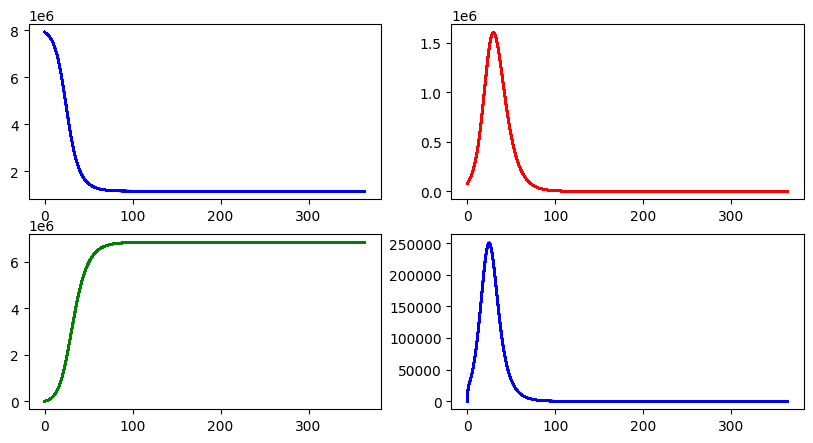

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0, 0].plot(range(T), x_sim.at[0, :, :].get(), color='blue',  alpha=0.1)
ax[0, 1].plot(range(T), x_sim.at[1, :, :].get(), color='red',   alpha=0.1)
ax[1, 0].plot(range(T), x_sim.at[2, :, :].get(), color='green', alpha=0.1)
ax[1, 1].plot(range(T), x_sim.at[3, :, :].get(), color='blue',  alpha=0.1)